In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import ipywidgets as widgets
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib.pyplot as plt
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly_resampler import FigureResampler, FigureWidgetResampler
import datetime as dt
from typing import Literal
import plotly.io as pio
pio.renderers.default='notebook'

### Read CSV

In [2]:
client_trades = pd.read_csv('./trades/ctrader_demo_trades_details_2024-04-18T02_21_51.345859Z.csv')
client_trades['execution_timestamp'] = pd.to_datetime(client_trades['execution_timestamp'], format='mixed')

# Remove un-closed trades
client_trades['lots'] = np.where(client_trades['trade_side'] == 2, -1, 1) * client_trades['volume']
client_trades = client_trades[~client_trades['position_id'].isin(client_trades.groupby('position_id').agg({'lots':sum}).query('lots != 0').index)]

In [3]:
client_trades[(client_trades['profit_usd'].isna()) & (client_trades['symbol'] == 'Step Index 400')]['execution_timestamp'].dt.date.groupby(client_trades[(client_trades['profit_usd'].isna()) & (client_trades['symbol'] == 'Step Index 400')]['execution_timestamp'].dt.date).count().describe()

count     23.000000
mean     102.608696
std       80.639906
min        1.000000
25%       41.000000
50%       84.000000
75%      134.500000
max      301.000000
Name: execution_timestamp, dtype: float64

Text(0.5, 1.0, 'Client Transaction Dates')

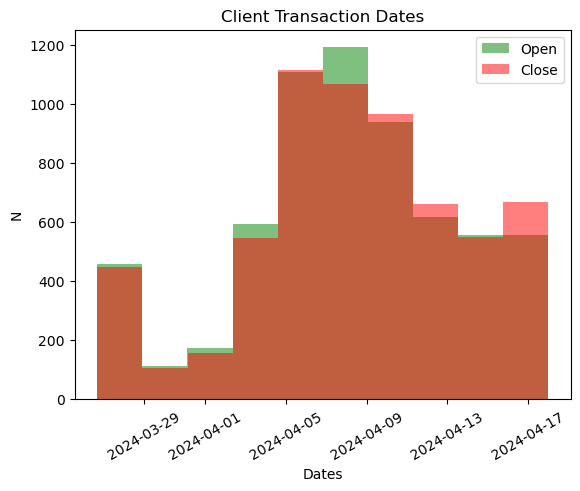

In [239]:
plt.figure()
plt.hist(client_trades['execution_timestamp'][client_trades['profit_usd'].isna()], color='green', alpha=0.5)
plt.hist(client_trades['execution_timestamp'][~client_trades['profit_usd'].isna()], color='red', alpha=0.5)
plt.legend(['Open', 'Close']);
plt.xlabel('Dates')
plt.ylabel('N')
plt.xticks(rotation=30)
plt.title('Client Transaction Dates')

In [4]:
def win_rate(trades):
    return np.where(trades > 0, 1, 0).mean()

def hit_ratio(trades):
    return trades[trades>0].sum()/np.abs(trades).sum()

### Get Client statistics per symbol per login

For:
* Per Symbol & Login ID
* Per Login ID
* Per Symbol

Look at: Trade count, PnL, Win Rate & Hit Ratio (Client-side).

In [241]:
# Stats Per login ID & symbol
stats_per_symbol_login_pos = client_trades[['login', 'symbol', 'position_id', 'profit_usd']].groupby(['login', 'symbol', 'position_id']).agg({'profit_usd': ['count', 'sum']}).droplevel(0, axis=1).groupby(['login', 'symbol']).agg({'count': 'sum', 'sum' : ['sum', 'mean' ,win_rate, hit_ratio]}).droplevel(0, axis=1)
stats_per_symbol_login_pos.columns = ['N Positions', 'Client PnL', 'Average Client PnL', 'Client Win Rate', 'Client Hit Ratio']
stats_per_symbol_login_pos.sort_values('Client PnL', ascending=False, inplace=True)

# Stats Per login ID
stats_per_login = client_trades[['login', 'position_id', 'profit_usd']].groupby(['login', 'position_id']).agg({'profit_usd': ['count', 'sum']}).droplevel(0, axis=1).groupby('login').agg({'count': 'sum', 'sum' : ['sum', 'mean' ,win_rate, hit_ratio]}).droplevel(0, axis=1)
stats_per_login.columns = ['N Positions', 'Client PnL', 'Average Client PnL', 'Client Win Rate', 'Client Hit Ratio']
stats_per_login.sort_values('Client PnL', ascending=False, inplace=True)

# Stats Per symbol
stats_per_symbol = client_trades[['profit_usd', 'symbol', 'position_id']].groupby(['symbol', 'position_id']).agg({'profit_usd': ['count', 'sum']}).droplevel(0, axis=1).groupby('symbol').agg({'count': 'sum', 'sum' : ['sum', 'mean' ,win_rate, hit_ratio]}).droplevel(0, axis=1)
stats_per_symbol.columns = ['N Positions', 'Client PnL', 'Average Client PnL', 'Client Win Rate', 'Client Hit Ratio']
stats_per_symbol.sort_values('Client PnL', ascending=False, inplace=True)

display(stats_per_symbol_login_pos.head(13), stats_per_login.head(10), stats_per_symbol)

/var/folders/h8/lhtyj0t14995hs6twl9cf01c0000gn/T/ipykernel_73394/1417035654.py:5: RuntimeWarning:

invalid value encountered in scalar divide

/var/folders/h8/lhtyj0t14995hs6twl9cf01c0000gn/T/ipykernel_73394/1417035654.py:5: RuntimeWarning:

invalid value encountered in scalar divide



,,N Positions,Client PnL,Average Client PnL,Client Win Rate,Client Hit Ratio
login,symbol,,,,,
2017858,Step Index 400,39,83676.00,2145.538462,1.000000,1.000000
2051310,Step Index 400,5,18851.84,3770.368000,1.000000,1.000000
2017858,Step Index 300,28,17160.27,612.866786,0.714286,0.791541
2032961,Step Index 300,52,16138.65,310.358654,0.961538,0.998634
2051310,Step Index 300,31,14381.07,463.905484,0.580645,0.807392
2032961,Step Index 400,52,13215.44,254.143077,1.000000,1.000000
2056192,Step Index 300,10,10203.00,1020.300000,1.000000,1.000000
2023680,Step Index 300,72,8610.93,119.596250,0.666667,0.773822
2028232,Step Index 400,3,5771.28,1923.760000,0.666667,0.999875


,N Positions,Client PnL,Average Client PnL,Client Win Rate,Client Hit Ratio
login,,,,,
2017858,67,100836.27,1505.018955,0.880597,0.945759
2051310,36,33232.91,923.136389,0.638889,0.893346
2032961,104,29354.09,282.250865,0.980769,0.999248
2056192,20,11435.00,571.750000,1.000000,1.000000
2028232,9,5840.49,730.061250,0.625000,0.991582
2054615,11,3661.08,332.825455,0.818182,0.759980
2046324,48,3659.60,76.241667,0.562500,0.897679
2019757,71,3501.30,50.018571,0.685714,0.544069
2055130,58,3466.84,59.773103,0.982759,0.999954


,N Positions,Client PnL,Average Client PnL,Client Win Rate,Client Hit Ratio
symbol,,,,,
Step Index 400,2366,116133.24,50.100621,0.600518,0.707721
Step Index 300,3913,-13333.47,-3.456954,0.480944,0.477752


### Get Top Client Statistics

In [242]:
top_pnls = stats_per_symbol_login_pos.sort_values('Client PnL', ascending=False).head(10)
display(stats_per_symbol_login_pos.sort_values('N Positions', ascending=False).head(10))
display(stats_per_symbol_login_pos.sort_values('Average Client PnL', ascending=False).head(10))
display(stats_per_symbol_login_pos[(stats_per_symbol_login_pos['N Positions'] > 50) & (stats_per_symbol_login_pos['Client Win Rate'] > 0.5)])

,,N Positions,Client PnL,Average Client PnL,Client Win Rate,Client Hit Ratio
login,symbol,,,,,
2005295,Step Index 300,644,-294.54,-0.457360,0.512422,0.345765
2015902,Step Index 300,256,-7.83,-0.030586,0.382812,0.424784
2051135,Step Index 300,229,-3300.96,-14.414672,0.375546,0.385269
2005461,Step Index 400,130,1823.56,14.027385,1.000000,1.000000
2012266,Step Index 300,114,86.52,0.758947,0.964912,0.748107
2056948,Step Index 300,104,-38.49,-0.370096,0.451923,0.342189
2052852,Step Index 400,100,-158.80,-1.588000,0.380000,0.389906
2053258,Step Index 300,90,144.00,1.600000,0.444444,0.516783
2024675,Step Index 300,90,-5825.55,-64.728333,0.466667,0.044220


,,N Positions,Client PnL,Average Client PnL,Client Win Rate,Client Hit Ratio
login,symbol,,,,,
2051310,Step Index 400,5,18851.84,3770.368000,1.000000,1.000000
2011585,Step Index 300,1,2895.00,2895.000000,1.000000,1.000000
2017858,Step Index 400,39,83676.00,2145.538462,1.000000,1.000000
2028232,Step Index 400,3,5771.28,1923.760000,0.666667,0.999875
2054436,Step Index 400,2,3425.60,1712.800000,1.000000,1.000000
2056192,Step Index 300,10,10203.00,1020.300000,1.000000,1.000000
2044705,Step Index 400,1,1008.00,1008.000000,1.000000,1.000000
2050368,Step Index 300,1,1002.00,1002.000000,1.000000,1.000000
2017858,Step Index 300,28,17160.27,612.866786,0.714286,0.791541


N Positions  Client PnL  Average Client PnL  \
login   symbol                                                        
2032961 Step Index 300           52    16138.65          310.358654   
        Step Index 400           52    13215.44          254.143077   
2023680 Step Index 300           72     8610.93          119.596250   
2005461 Step Index 400          130     1823.56           14.027385   
2051135 Step Index 400           82     1749.20           21.331707   
2055140 Step Index 400           79      191.84            2.428354   
2012266 Step Index 300          114       86.52            0.758947   
2054966 Step Index 300           74       62.10            1.129091   
2005295 Step Index 300          644     -294.54           -0.457360   
2019757 Step Index 400           55    -1171.20          -21.294545   

                        Client Win Rate  Client Hit Ratio  
login   symbol                                             
2032961 Step Index 300         0.961538          0.998634  
        Step Index 400         1.000000          1.000000  
2023680 Step Index 300         0.666667          0.773822  
2005461 Step Index 400         1.000000          1.000000  
2051135 Step Index 400         0.829268          0.694997  
2055140 Step Index 400         1.000000          1.000000  
2012266 Step Index 300         0.964912          0.748107  
2054966 Step Index 300         0.527273          0.561739  
2005295 Step Index 300         0.512422          0.345765  
2019757 Step Index 400         0.618182          0.483293

In [243]:
# Using query method
display(client_trades[['login', 'profit_usd', 'symbol']].dropna().query('symbol == "Step Index 300" & login == 2017858').head(10))

# Or by using logical statements:
# display(client_trades[['login', 'profit_usd', 'symbol']].dropna()[(client_trades['symbol'] == "Step Index 300") & (client_trades['login'] == 2017858)].head(10))

,login,profit_usd,symbol
156,2017858,3.51,Step Index 300
158,2017858,1770.00,Step Index 300
160,2017858,1785.00,Step Index 300
162,2017858,1785.00,Step Index 300
164,2017858,1770.00,Step Index 300
180,2017858,9.96,Step Index 300
182,2017858,9.93,Step Index 300
184,2017858,9.87,Step Index 300
186,2017858,999.00,Step Index 300
188,2017858,993.00,Step Index 300


In [244]:
client_trades.groupby(['symbol', 'trade_side', 'position_id']).agg({'profit_usd' : ['count', 'sum']}).droplevel(0, axis=1).groupby(['symbol', 'trade_side']).agg({'count' : 'count', 'sum' : 'sum'})

count       sum
symbol         trade_side                 
Step Index 300 1            3857  -1630.95
               2            3857 -11702.52
Step Index 400 1            2318  25915.24
               2            2318  90218.00

In [452]:
from scipy import stats

a= -client_trades.groupby('position_id').agg({"profit_usd":sum})
a['win_rate'] = np.where(a>=0,1,0)
win_rate = a['win_rate'].mean()
hit_ratio = a['profit_usd'][a['profit_usd']>0].sum()/np.abs(a['profit_usd']).sum()
print(f'Company Win Rate (CT): {win_rate}')
print(f'Company Hit Ratio (CT): {hit_ratio}')
print()

for symbol in ['Step Index 300', 'Step Index 400']:
    company_pnls = -client_trades[client_trades['symbol'] == symbol].groupby('position_id').agg({"profit_usd" : sum}).rename(columns={'profit_usd' : 'Company PnL'})

    company_pnls['win_rate'] = np.where(company_pnls>=0,1,0)
    win_rate = company_pnls['win_rate'].mean()
    hit_ratio = company_pnls['Company PnL'][company_pnls['Company PnL']>0].sum()/np.abs(company_pnls['Company PnL']).sum()

    print(f'Company Win Rate ({symbol}): {win_rate}')
    print(f'Company Hit Ratio ({symbol}): {hit_ratio}')
    print()

Company Win Rate (CT): 0.47417004048582995
Company Hit Ratio (CT): 0.41125646877476757

Company Win Rate (Step Index 300): 0.5190562613430127
Company Hit Ratio (Step Index 300): 0.5222481176533367

Company Win Rate (Step Index 400): 0.3994823123382226
Company Hit Ratio (Step Index 400): 0.2922794130798826



In [76]:
company_pnls

1         -0.06
3          0.45
5          0.42
7         -0.54
44        -8.49
          ...  
12704   -555.00
12715      1.11
12718     -1.05
12720     -1.08
12722     -0.00
Name: profit_usd, Length: 3883, dtype: float64

1 buy
2 sell

In [468]:
client_trades.query('position_id == 2388370')

,execution_timestamp,trader_id,login,main_id,status,deal_id,spread_revenue,deal_type,trade_side,book_type,market,symbol,position_id,volume,volume_usd,m,price,profit_usd,contract_count,lots
927,2024-03-29 00:07:39.989,18877,2017858,18877,NaN,3536296,0,1,2,2,Step Indices,Step Index 400,2388370,5.0,495140.0,1000,9903.0,NaN,0,-5.0
928,2024-04-04 08:34:57.565,18877,2017858,18877,NaN,3667008,0,1,1,2,Step Indices,Step Index 400,2388370,5.0,490660.0,1000,9813.0,4500.0,1,5.0


In [473]:
client_trades['trader_id'].unique().shape

(513,)

In [467]:
a = client_trades.query('login == 2017858 & symbol == "Step Index 400"')
a[a['execution_timestamp'].apply(pd.Timestamp) >= pd.Timestamp(year=2024, month=4, day = 2)].sort_values('position_id', ascending=True)

,execution_timestamp,trader_id,login,main_id,status,deal_id,spread_revenue,deal_type,trade_side,book_type,market,symbol,position_id,volume,volume_usd,m,price,profit_usd,contract_count,lots
928,2024-04-04 08:34:57.565,18877,2017858,18877,NaN,3667008,0,1,1,2,Step Indices,Step Index 400,2388370,5.0,490660.0,1000,9813.0,4500.0,1,5.0
930,2024-04-04 08:34:57.617,18877,2017858,18877,NaN,3667009,0,1,1,2,Step Indices,Step Index 400,2388371,5.0,490660.0,1000,9813.0,4520.0,1,5.0
932,2024-04-04 08:34:57.617,18877,2017858,18877,NaN,3667010,0,1,1,2,Step Indices,Step Index 400,2388372,5.0,490660.0,1000,9813.0,4540.0,1,5.0
934,2024-04-04 08:34:57.617,18877,2017858,18877,NaN,3667011,0,1,1,2,Step Indices,Step Index 400,2388373,5.0,490660.0,1000,9813.0,4540.0,1,5.0
4250,2024-04-06 13:44:19.576,18877,2017858,18877,NaN,3751680,0,1,1,2,Step Indices,Step Index 400,2520302,5.0,487560.0,1000,9751.0,NaN,0,5.0
4251,2024-04-08 10:06:47.025,18877,2017858,18877,NaN,3779626,0,1,2,2,Step Indices,Step Index 400,2520302,5.0,492500.0,1000,9850.2,4960.0,1,-5.0
4252,2024-04-06 13:44:23.034,18877,2017858,18877,NaN,3751681,0,1,1,2,Step Indices,Step Index 400,2520303,5.0,487580.0,1000,9752.2,NaN,0,5.0
4253,2024-04-08 10:06:47.080,18877,2017858,18877,NaN,3779627,0,1,2,2,Step Indices,Step Index 400,2520303,5.0,492500.0,1000,9850.2,4900.0,1,-5.0
4254,2024-04-06 13:44:24.725,18877,2017858,18877,NaN,3751682,0,1,1,2,Step Indices,Step Index 400,2520304,5.0,487620.0,1000,9753.0,NaN,0,5.0
4255,2024-04-08 10:06:47.080,18877,2017858,18877,NaN,3779628,0,1,2,2,Step Indices,Step Index 400,2520304,5.0,492500.0,1000,9850.2,4860.0,1,-5.0


count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: profit_usd, dtype: float64


,execution_timestamp,trader_id,login,main_id,status,deal_id,spread_revenue,deal_type,trade_side,book_type,market,symbol,position_id,volume,volume_usd,m,price,profit_usd,contract_count,lots


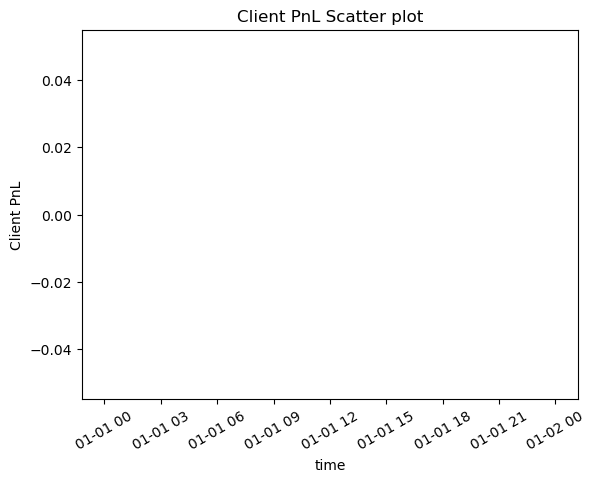

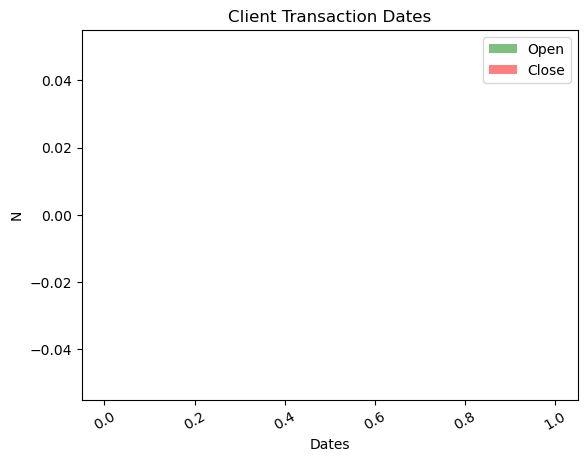

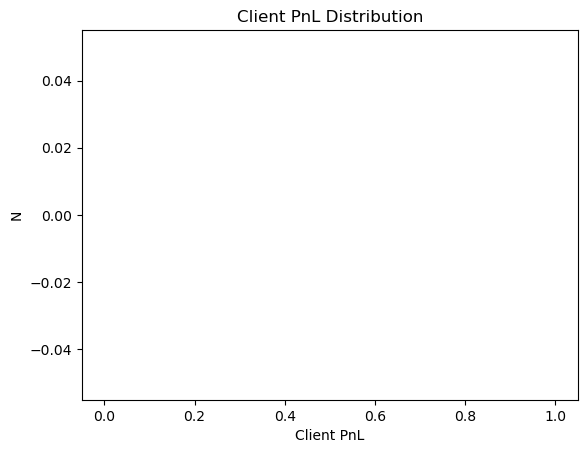

In [456]:
top_trades = client_trades.query('login == 2017858 & symbol == "Step Index 400"')
top_closed_trades = top_trades[['execution_timestamp', 'position_id', 'profit_usd']].sort_values('execution_timestamp', ascending=False).dropna()
# top_trades[top_trades['position_id'] == 2520302] 
plt.scatter(top_closed_trades['execution_timestamp'], top_closed_trades['profit_usd'], marker='x', label='Pnl')
plt.xlabel('time')
plt.xticks(rotation=30)
plt.ylabel('Client PnL')
plt.title('Client PnL Scatter plot')

plt.figure()
plt.hist(top_trades['execution_timestamp'][top_trades['profit_usd'].isna()], bins=50, color='green', alpha=0.5)
plt.hist(top_trades['execution_timestamp'][~top_trades['profit_usd'].isna()], bins=50, color='red', alpha=0.5)
plt.legend(['Open', 'Close']);
plt.xlabel('Dates')
plt.ylabel('N')
plt.xticks(rotation=30)
plt.title('Client Transaction Dates')

plt.figure()
plt.hist(top_closed_trades['profit_usd'], bins=80)
plt.xlabel('Client PnL')
plt.ylabel('N')
plt.title('Client PnL Distribution')
# top_trades.sort_values('position_id', ascending=False)['profit_usd'].dropna().reset_index(drop=True).plot()
print(top_closed_trades['profit_usd'].describe())
display(top_trades.sort_values('position_id', ascending=True))

In [364]:
client_trades.query('position_id == 2655782')

,execution_timestamp,trader_id,login,main_id,status,deal_id,spread_revenue,deal_type,trade_side,book_type,market,symbol,position_id,volume,volume_usd,m,price,profit_usd,contract_count,lots
10897,2024-04-14 08:23:33.339,57938,2056919,57938,NaN,3965898,0,1,2,2,Step Indices,Step Index 300,2655782,5.0,530960.0,500,10619.4,NaN,0,-5.0
10898,2024-04-14 08:25:18.166,57938,2056919,57938,NaN,3965901,0,1,2,2,Step Indices,Step Index 300,2655782,5.0,530945.0,500,10619.1,NaN,0,-5.0
10899,2024-04-14 12:06:15.158,57938,2056919,57938,NaN,3967139,0,1,1,2,Step Indices,Step Index 300,2655782,10.0,1071640.0,2000,10716.9,-9765.0,1,10.0


In [22]:
symbol_query = 'symbol == "Step Index 400"'
durations = client_trades[client_trades['position_id'].isin(client_trades.query(symbol_query)['position_id'])].sort_values('position_id', ascending=False).groupby('position_id').agg({'execution_timestamp': [min, contract_duration], 'profit_usd' : sum}).droplevel(0,axis=1)
durations.columns = ['start_date','contract_duration', 'total_pnl']
durations['contract_duration_hrs'] = durations['contract_duration'].dt.total_seconds() / 3600

stats = durations['total_pnl'].describe()
stats['skew'] = durations['total_pnl'].skew()
stats['kurt'] = durations['total_pnl'].kurt()
stats

count    2318.000000
mean       50.100621
std       491.855830
min     -2200.000000
25%        -2.320000
50%         0.800000
75%        10.760000
max      5660.000000
skew        6.561224
kurt       64.993808
Name: total_pnl, dtype: float64

In [35]:
def contract_duration(series):
    return series.max() - series.min()

symbol_query = 'symbol == "Step Index 400"'
durations = client_trades[client_trades['position_id'].isin(client_trades.query(symbol_query)['position_id'])].sort_values('position_id', ascending=False).groupby('position_id').agg({'execution_timestamp': [min, contract_duration], 'profit_usd' : sum}).droplevel(0,axis=1)
durations.columns = ['start_date','contract_duration', 'total_pnl']
durations['contract_duration_hrs'] = durations['contract_duration'].dt.total_seconds().astype(int) / 3600
# display(durations)

# (durations['contract_duration'].dt.total_seconds() / 60).hist(bins=150)

import plotly.express as px
query = 'total_pnl == total_pnl & contract_duration_hrs < 24'
print(durations.query(query)['contract_duration_hrs'].count())
print(durations.query(query)['contract_duration_hrs'].min())
fig = px.scatter(durations.query(query).reset_index(), x='contract_duration_hrs', y='total_pnl', title=symbol_query, custom_data = durations.index.name)
fig.update_traces(marker=dict(symbol='cross'), 
                  hovertemplate = "<br>".join([
                  "Hours: %{x}",   
                  "PnL: %{y}",  
                  "Position ID: %{customdata}"
    ]))



# plt.grid(True)
# plt.scatter(durations['contract_duration'].dt.total_seconds() / 3600, durations['total_pnl'], marker='+')
# plt.title(query)
# plt.xlabel('Contract Duration (mins)');
# plt.ylabel('Total PnL ($)');

2121
0.0002777777777777778


In [36]:
durations.query(query)['contract_duration_hrs'].describe()

count    2121.000000
mean        1.647854
std         3.770879
min         0.000278
25%         0.023889
50%         0.138056
75%         0.817222
max        23.985556
Name: contract_duration_hrs, dtype: float64

In [451]:
client_trades.query('position_id == 2575569')

,execution_timestamp,trader_id,login,main_id,status,deal_id,spread_revenue,deal_type,trade_side,book_type,market,symbol,position_id,volume,volume_usd,m,price,profit_usd,contract_count,lots
9331,2024-04-11 00:04:23.459,32240,2031221,32240,NaN,3853303,0,1,2,2,Step Indices,Step Index 400,2575569,5.0,497360.0,1000,9946.6,NaN,0,-5.0
9332,2024-04-11 00:53:50.028,32240,2031221,32240,NaN,3853457,0,1,1,2,Step Indices,Step Index 400,2575569,5.0,496320.0,1000,9926.2,1020.0,1,5.0


<Axes: >

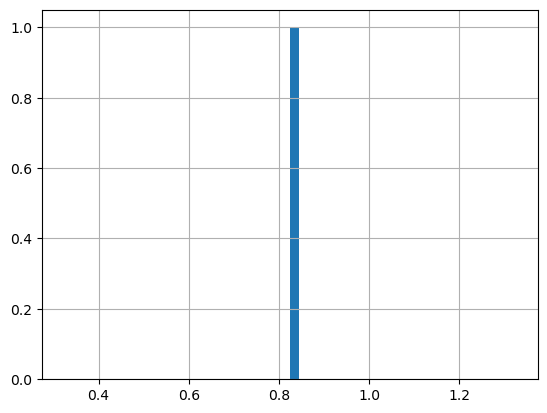

In [450]:
durations.query('total_pnl < -1000')['contract_duration_hrs'].hist(bins=50)

count      67.000000
mean     1505.018955
std      1705.621405
min      -795.000000
25%       230.000000
50%       993.000000
75%      2120.000000
max      4960.000000
Name: profit_usd, dtype: float64


,execution_timestamp,trader_id,login,main_id,status,deal_id,spread_revenue,deal_type,trade_side,book_type,market,symbol,position_id,volume,volume_usd,m,price,profit_usd,contract_count
4285,2024-04-12 01:08:45.226,18877,2017858,18877,NaN,3884676,0,1,2,2,Step Indices,Step Index 300,2520329,5.0,530960.0,500,10619.4,-780.0,1
4284,2024-04-06 13:46:06.374,18877,2017858,18877,NaN,3751717,0,1,1,2,Step Indices,Step Index 300,2520329,5.0,531725.0,1000,10635.0,NaN,0
4283,2024-04-12 01:08:42.249,18877,2017858,18877,NaN,3884675,0,1,2,2,Step Indices,Step Index 300,2520328,5.0,530975.0,500,10619.7,-750.0,1
4282,2024-04-06 13:46:06.044,18877,2017858,18877,NaN,3751716,0,1,1,2,Step Indices,Step Index 300,2520328,5.0,531740.0,1000,10634.7,NaN,0
4281,2024-04-12 01:08:34.285,18877,2017858,18877,NaN,3884672,0,1,2,2,Step Indices,Step Index 300,2520327,5.0,530975.0,500,10619.7,-750.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126,2024-03-27 16:55:58.196,18877,2017858,18877,NaN,3509537,0,1,1,2,Step Indices,Step Index 400,2374666,5.0,498740.0,1000,9975.4,460.0,1
123,2024-03-27 16:41:10.012,18877,2017858,18877,NaN,3509418,0,1,2,2,Step Indices,Step Index 400,2374664,5.0,499260.0,1000,9985.4,NaN,0
124,2024-03-27 16:55:58.196,18877,2017858,18877,NaN,3509536,0,1,1,2,Step Indices,Step Index 400,2374664,5.0,498740.0,1000,9975.4,500.0,1
122,2024-03-27 16:55:58.135,18877,2017858,18877,NaN,3509535,0,1,1,2,Step Indices,Step Index 400,2374663,5.0,498740.0,1000,9975.4,500.0,1


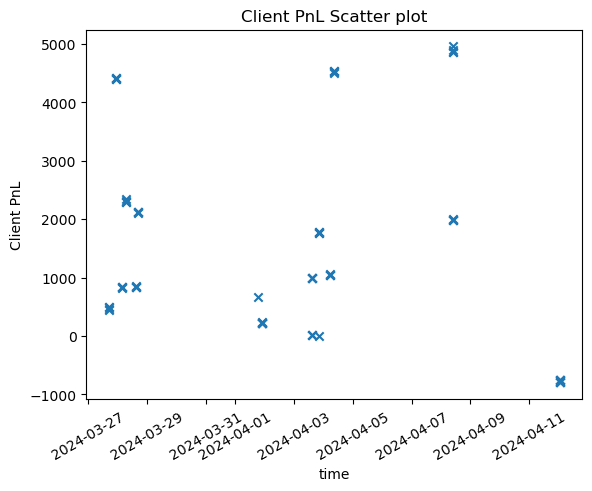

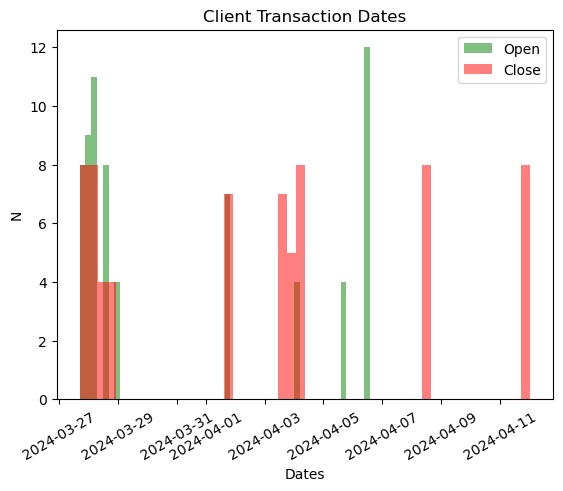

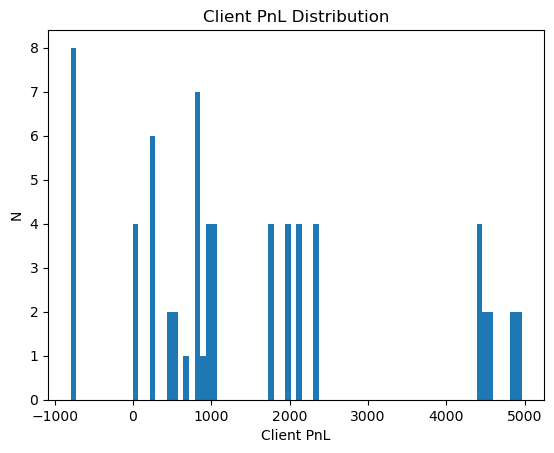

In [77]:
top_trades = client_trades[client_trades['login'] == 2017858]
top_closed_trades = top_trades[['execution_timestamp', 'position_id', 'profit_usd']].sort_values('execution_timestamp', ascending=False).dropna()
# top_trades[top_trades['position_id'] == 2520302] 
plt.scatter(top_closed_trades['execution_timestamp'], top_closed_trades['profit_usd'], marker='x', label='Pnl')
plt.xlabel('time')
plt.xticks(rotation=30)
plt.ylabel('Client PnL')
plt.title('Client PnL Scatter plot')

plt.figure()
plt.hist(top_trades['execution_timestamp'][top_trades['profit_usd'].isna()], bins=50, color='green', alpha=0.5)
plt.hist(top_trades['execution_timestamp'][~top_trades['profit_usd'].isna()], bins=50, color='red', alpha=0.5)
plt.legend(['Open', 'Close']);
plt.xlabel('Dates')
plt.ylabel('N')
plt.xticks(rotation=30)
plt.title('Client Transaction Dates')

plt.figure()
plt.hist(top_closed_trades['profit_usd'], bins=80)
plt.xlabel('Client PnL')
plt.ylabel('N')
plt.title('Client PnL Distribution')
# top_trades.sort_values('position_id', ascending=False)['profit_usd'].dropna().reset_index(drop=True).plot()
print(top_closed_trades['profit_usd'].describe())
display(top_trades.sort_values('position_id', ascending=False))

In [123]:
client_trades.groupby('position_id').agg({'position_id' : 'count'}).query('position_id > 2')

,position_id
position_id,
2368208,3
2415265,3
2416324,3
2439074,3
2443357,3
...,...
2679565,3
2679566,3
2679572,3


In [125]:
client_trades.query('position_id == 2589375')

,execution_timestamp,trader_id,login,main_id,status,deal_id,spread_revenue,deal_type,trade_side,book_type,market,symbol,position_id,volume,volume_usd,m,price,profit_usd,contract_count
9776,2024-04-11 19:19:04.315,55985,2054966,55985,NaN,3880508,0,1,1,2,Step Indices,Step Index 300,2589375,0.01,1060.51,2,10605.6,NaN,0
9777,2024-04-11 19:21:13.945,55985,2054966,55985,NaN,3880572,0,1,2,2,Step Indices,Step Index 300,2589375,0.03,3182.34,3,10608.0,0.24,1
9778,2024-04-11 19:21:45.652,55985,2054966,55985,NaN,3880575,0,1,1,2,Step Indices,Step Index 300,2589375,0.04,4242.64,8,10607.1,0.18,1
9779,2024-04-11 19:26:52.708,55985,2054966,55985,NaN,3880594,0,1,2,2,Step Indices,Step Index 300,2589375,0.04,4244.44,4,10611.3,0.84,1
9780,2024-04-11 19:30:13.688,55985,2054966,55985,NaN,3880631,0,1,1,2,Step Indices,Step Index 300,2589375,0.04,4242.16,8,10605.9,1.08,1
9781,2024-04-11 19:30:41.531,55985,2054966,55985,NaN,3880634,0,1,2,2,Step Indices,Step Index 300,2589375,0.04,4241.92,4,10604.4,-0.30,1
9782,2024-04-11 19:31:01.436,55985,2054966,55985,NaN,3880639,0,1,1,2,Step Indices,Step Index 300,2589375,0.04,4241.68,8,10604.7,-0.06,1
9783,2024-04-11 19:31:24.506,55985,2054966,55985,NaN,3880680,0,1,1,2,Step Indices,Step Index 300,2589375,0.02,2120.78,4,10603.8,NaN,0
9784,2024-04-11 19:36:06.413,55985,2054966,55985,NaN,3880857,0,1,2,2,Step Indices,Step Index 300,2589375,0.04,4242.28,4,10605.9,0.66,1
